In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from netCDF4 import Dataset
import pandas as pd
import xarray as xr
import matplotlib.colors as colors
import calendar

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1 import make_axes_locatable


import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.colors
import matplotlib as mpl
import matplotlib.cm as cm


import shapely.geometry as sgeom

import shapefile as shp

import datetime as dt
import salem
import glob
#import warnings
#warnings.filterwarnings("ignore")
# from osgeo import gdal # Import the GDAL library

In [4]:
files= glob.glob('/guiana/reanalise_era5*.nc')
li = sorted(files)


full = xr.open_mfdataset(li, combine='by_coords')

#Correção da unidade dos dados  =>  m--> mm/day
full['tp'] = full.tp *1000 #[mm]

tp =  full.tp.sel(expver=1)



#Valor máx diario
max_1h = tp.rolling(time = 1).max()
pmp_1h = max_1h.groupby('time.month').sum()


# Máxima móvel de 12h:
max_12h = tp.rolling(time = 12).max()  
pmp_12h = max_12h.groupby('time.month').sum()



# Máxima móvel de 24h:
max_24h = tp.rolling(time=24).max()  
pmp_24h = max_24h.groupby('time.month').sum()


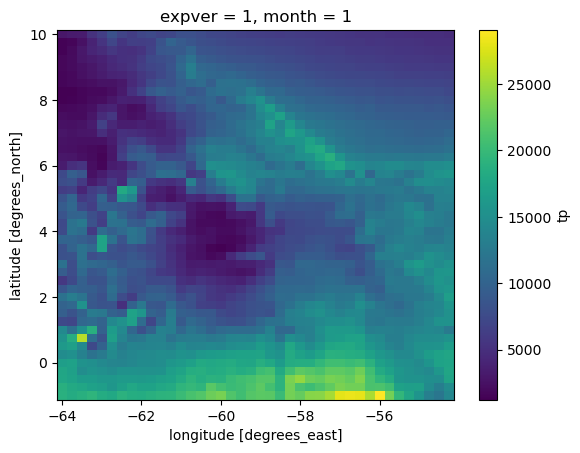

In [5]:
pmp_1h.sel(month=1).plot()

In [6]:
# Palette -  Rain
c = ["#b4f0f0", "#96d2fa", "#78b9fa", "#3c95f5", "#1e6deb", "#1463d2", "#0fa00f", "#28be28", "#50f050", "#72f06e", "#b3faaa", "#fff9aa", "#ffe978", "#ffc13c", "#ffa200", "#ff6200", "#ff3300", "#ff1500", "#c00100", "#a50200", "#870000", "#653b32"]
cmap = matplotlib.colors.ListedColormap(c)
cmap.set_over('#000000')
cmap.set_under('#aaaaaa')

extent = [-62.0,1.1,-56.0,9.0]
min_lon = extent[0]; max_lon = extent[2]; min_lat = extent[1]; max_lat = extent[3]


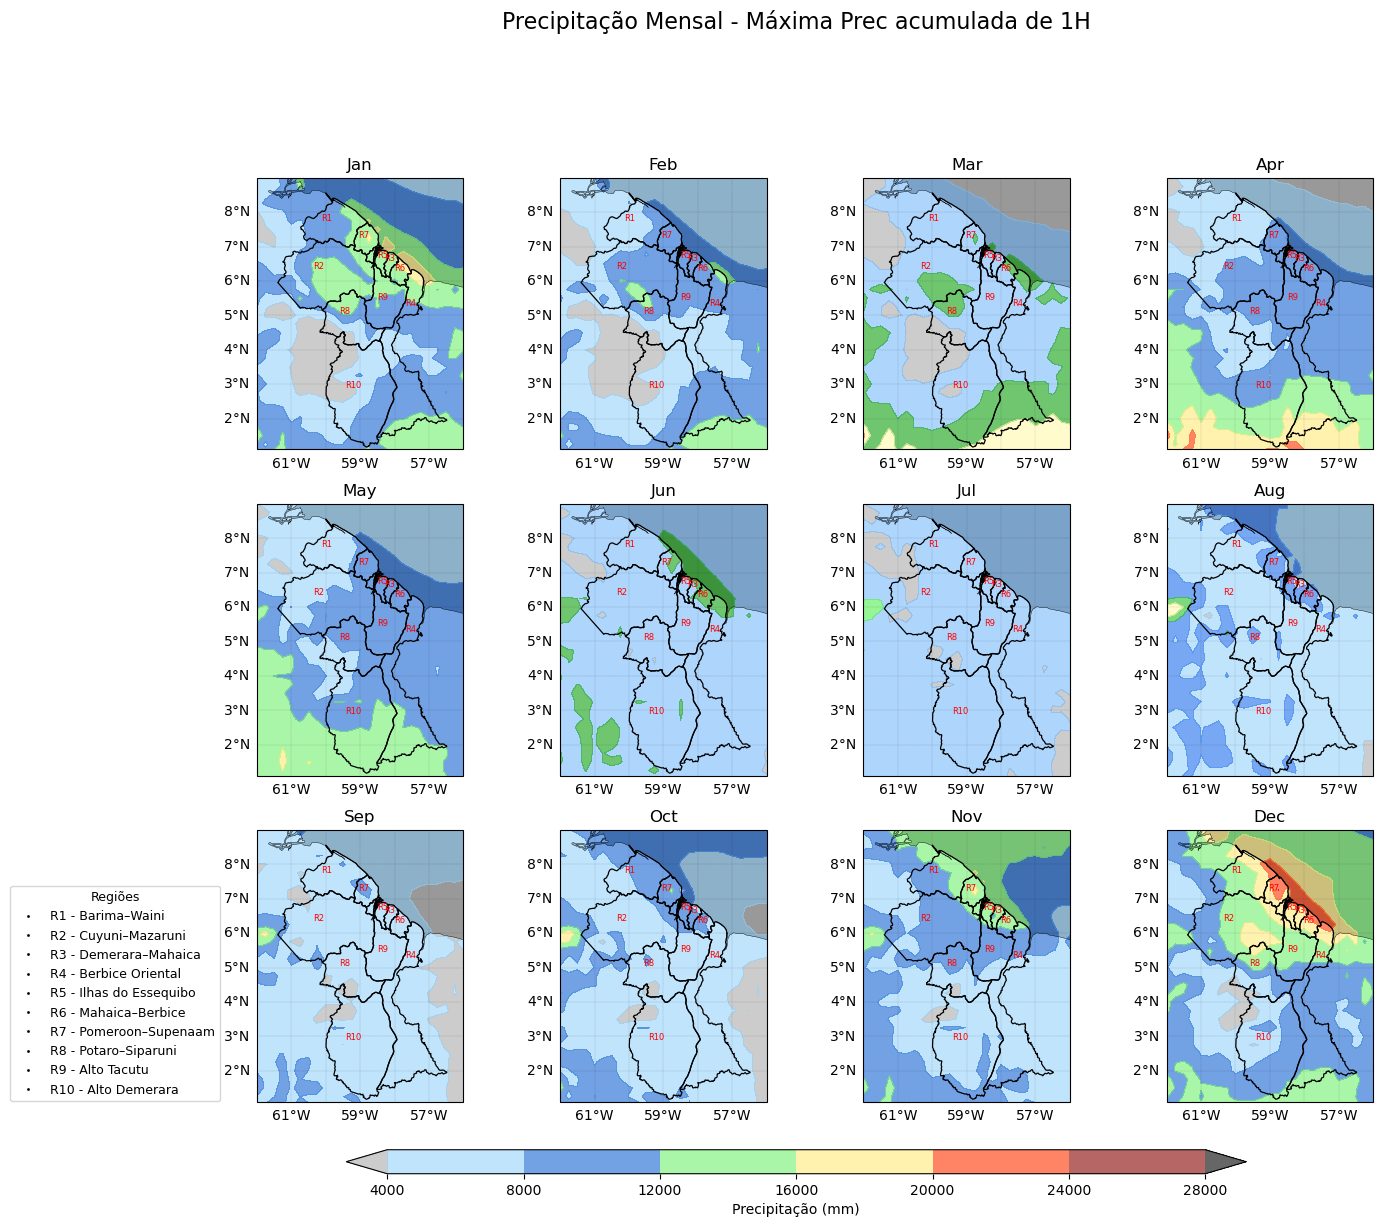

In [7]:
# Paises 
cidades_legendas = {
    "R1": (-59.813, 7.6902, "Barima–Waini"),
    "R2": (-60.040, 6.300, "Cuyuni–Mazaruni"),
    "R3": (-57.980, 6.530, "Demerara–Mahaica"),
    "R4": (-57.358, 5.218, "Berbice Oriental"),
    "R5": (-58.200, 6.6114, "Ilhas do Essequibo"),
    "R6": (-57.700, 6.245, "Mahaica–Berbice"),
    "R7": (-58.733, 7.184, "Pomeroon–Supenaam"),
    "R8": (-59.28, 5.00, "Potaro–Siparuni"),
    "R9": (-58.1802, 5.40, "Alto Tacutu"),
    "R10": (-58.96, 2.85, "Alto Demerara"),
}

# PONTOS
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=3) for cidade in cidades_legendas]
labels = [f"{cidade} - {nome_cidade}" for cidade, (_, _, nome_cidade) in cidades_legendas.items()]

# fig (3l e 4col)
fig, axs = plt.subplots(3, 4, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# LOOP
for i, ax in enumerate(axs.flatten()):
    # clima = max_1h.groupby('time.month').mean('time')
    month = pmp_1h.sel(month=i + 1)

    img_extent = [extent[0], extent[2], extent[1], extent[3]]
    ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

    ocean = ax.add_feature(cfeature.OCEAN, facecolor='gray')
    shapefile = list(shpreader.Reader('/guiana/shapefile/guy_admbnd_adm1_2021.shp').geometries())
    ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.9)

    ax.coastlines(resolution='10m', color='black', linewidth=0.3)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='black', alpha=0.3, linestyle='--', linewidth=0.25,
                      xlocs=np.arange(-180, 180, 1), ylocs=np.arange(-90, 90, 1), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    S1 = ax.contourf(month.longitude, month.latitude, month, transform=ccrs.PlateCarree(), cmap=cmap, extend='both', alpha=0.6)

    nome_mes = calendar.month_abbr[i + 1]  
    ax.set_title(f'{nome_mes}')

    # cidades
    for cidade, (lon, lat, nome_cidade) in cidades_legendas.items():
        ax.text(lon, lat, f"{cidade}", color='red', size=6, ha='right', va='bottom', transform=ccrs.PlateCarree())

# pontos e cbar

legenda = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.12, 0.2), title="Regiões", fontsize=9)
plt.setp(legenda.get_title(), fontsize=9)

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
cb = plt.colorbar(S1, cax=cbar_ax, orientation='horizontal', label='Precipitação (mm)')


# TITULOS
plt.suptitle('Precipitação Mensal - Máxima Prec acumulada de 1H', fontsize=16, y=1.02) #Maximum accumulated Prec of 1H
plt.savefig('climatologia_prec_guiana_1h.png')
plt.show()
